# Part C: Using a DNN to Estimate Area Of Future Fires


In [1]:
import pandas as pd

bushfires_df = pd.read_csv("/kaggle/input/yicte-bushfires-over-time/data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne
0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0
1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0
2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0
3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0
4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0
...,...,...,...,...,...,...,...
6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3
6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3
6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9
6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2


In [2]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [3]:
# Group by week, average/sum, add a 'year' feature
grouped_df = bushfires_df.groupby(pd.Grouper(freq='W', key='acq_date'))

df = pd.DataFrame()

df['scan'] = grouped_df['scan'].mean()
df['max_t_syd'] = grouped_df['max_t_syd'].mean()
df['max_t_bne'] = grouped_df['max_t_bne'].mean()
df['time_sin'] = grouped_df['time_sin'].first()
df['time_cos'] = grouped_df['time_cos'].first()
df['year'] = grouped_df['year'].first() - 2000 # we'll count the years since approx when the data starts.

df = df.dropna()

In [4]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [5]:
train_dataset = train_dataset.sort_values(["scan", "acq_date"])

train_dataset

,scan,max_t_syd,max_t_bne,time_sin,time_cos,year
acq_date,,,,,,
2010-05-30,3.316667,18.166667,21.933333,0.601624,-0.798779,10.0
2008-02-24,3.933333,25.783333,31.500000,0.746972,0.664855,8.0
2004-02-29,7.416667,25.216667,30.866667,0.811539,0.584298,4.0
2009-03-15,7.485714,25.400000,27.171429,0.920971,0.389630,9.0
2016-02-07,7.500000,26.857143,31.171429,0.523416,0.852078,16.0
...,...,...,...,...,...,...
2012-10-21,1845.114286,26.871429,28.214286,-0.965740,0.259512,12.0
2002-11-03,2257.785714,23.985714,27.000000,-0.891981,0.452072,2.0
2012-10-28,2311.142857,21.300000,27.785714,-0.927542,0.373720,12.0


In [6]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu'), # Input layer
        tf.keras.layers.Dense(64, activation='relu'), # Hidden layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1) # Output layer
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.))
    return model

In [8]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [9]:
model = build_and_compile_model()

history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=0, epochs=1600)

In [10]:
pd.DataFrame(history.history)

,loss,val_loss
0,188.141769,165.677612
1,163.986237,154.013428
2,159.387909,153.916092
3,159.539810,153.938263
4,158.806656,153.682159
...,...,...
1595,114.591423,114.905197
1596,114.616081,117.453758
1597,113.424889,116.004112
1598,113.645157,115.931564


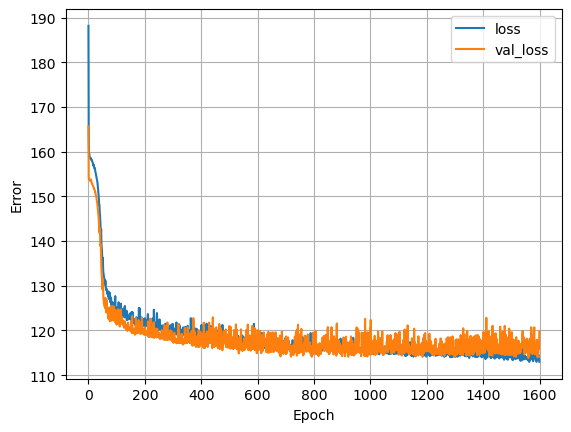

In [11]:
plot_loss(history)

7/7 [==============================] - 0s 2ms/step


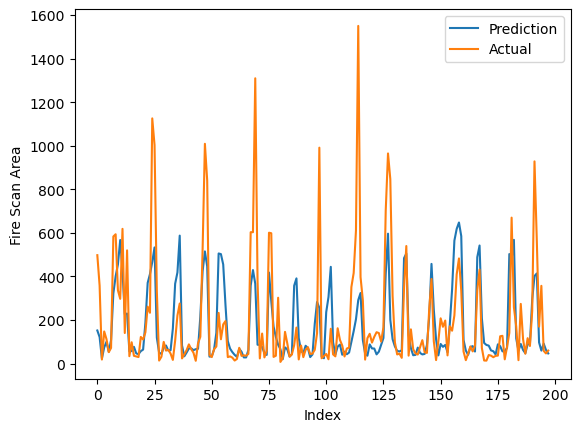

In [12]:
plt.plot(model.predict(test_features), label="Prediction")
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [13]:
# testing with some crazy data just because it's funny
new_data = {
    "max_t_syd": [34.023],
    "max_t_bne": [35.253],
    "time_sin": [0.017213],
    "time_cos": [0.999852],
    "year": [52.0]
}

new_df = pd.DataFrame(data=new_data)

model.predict(new_df)

1/1 [==============================] - 0s 19ms/step


array([[148.35712]], dtype=float32)

In [14]:
model.save("/kaggle/working/model.keras")